In [ ]:
export HOME=/data/vision/polina/users/clintonw
export PATH=$PATH:/data/vision/polina/shared_software/anaconda3/bin
export PROJ=/data/vision/polina/projects/wmh/clintonw
source activate clinton
cd "$HOME/code/vision_final/scripts"

In [171]:
import shutil
import importlib
import itertools
import glob, os
from os.path import *

import scipy.stats as stats
import scipy.optimize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count() - 2

import copy
import niftiutils.io as io

In [172]:
import torch
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import util
import analysis as ana

import networks.base as nets
import datasets.common as datasets
import datasets.mnist as mnist
import datasets.cifar as cifar
import scripts.train_classifier as main
nn = torch.nn

In [173]:
import warnings
warnings.filterwarnings("ignore")

#np.set_printoptions(suppress=True)

In [520]:
importlib.reload(util);

In [516]:
arg_list = util.get_ordered_experiments()

In [553]:
print(util.args_to_sh(arg_list[3], n_gpus=4))

nohup ./srunner.sh cls 4 --N_train 1875 --u_arch film --arch ae > srun13.out 2> srun13.err < /dev/null &


In [ ]:
nohup ./srunner.sh cls 2 --noise_p 0.0 --u_arch cat --arch dense > srun7.out 2> srun7.err < /dev/null &

In [555]:
print(util.args_to_sh(arg_list[3], slurm=False, exc_gpu=1))

CUDA_VISIBLE_DEVICES=1,2,3 nohup python train_classifier.py --N_train 1875 --u_arch film --arch ae > py28.out 2> py28.err < /dev/null &


In [ ]:
CUDA_VISIBLE_DEVICES=1,2,3 nohup python train_classifier.py --N_train 1875 --arch all-conv --u_arch cat > py5.out 2> py5.err < /dev/null &

In [ ]:
python train_classifier.py --epochs 1 --arch ae

In [518]:
args = main.get_args(arg_list[0])

In [487]:
util.clean_df()

In [ ]:
[os.remove(fn) for fn in glob.glob('logs/events*')]

In [ ]:
[os.removedirs(fn) for fn in glob.glob('logs/*') if len(os.listdir(fn))==0]

In [ ]:
glob.glob('logs/*')

In [ ]:
[os.remove(fn) for fn in glob.glob('data/mnist/*.npy')]

In [ ]:
glob.glob('data/fmnist/*.npy')

In [ ]:
[os.remove(fn) for fn in glob.glob('scripts/*.err')]

## df analysis

In [510]:
import seaborn as sns
csv_path = '/data/vision/polina/users/clintonw/code/vision_final/results.csv'
df = pd.read_csv(csv_path, index_col=0)
df = df[(df['epochs'] > 5) & (df['acc'] > 0)]

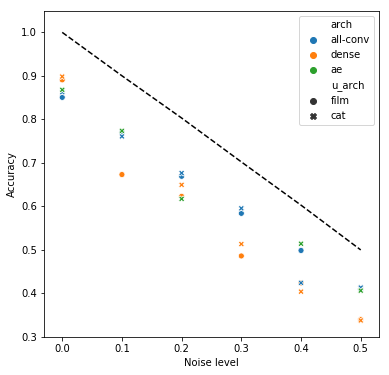

In [514]:
df_sub = df[(df['dataset'] == 'fmnist') & (df['nU'] == 10) & (df['N_train'] == 15000) & (df['noise_p'] >= 0)]

plt.figure(figsize=(6,6))
x = [0,.1,.2,.3,.4,.5]
y = [df.loc[df['noise_p'] == p, 'emp_est_acc'][0] for p in x]
plt.plot(x, y, 'k--')

sns.scatterplot(x='noise_p', y='acc', data=df_sub, hue='arch', style='u_arch')
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.ylim(0.3,1.05);

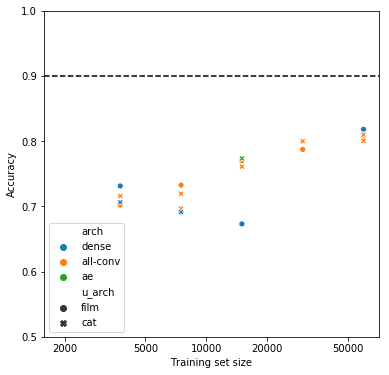

In [515]:
df_sub = df[(df['dataset'] == 'fmnist') & (df['nU'] == 10) & (df['noise_p'] == 0.1)]
x_filt = [60000//2**n for n in range(6)]
df_sub = df_sub[df_sub['N_train'].isin(x_filt)]

plt.figure(figsize=(6,6))
plt.axhline(y=df_sub['true_est_acc'][0], linestyle='--', color='k')
df_sub['lnN_train'] = np.log(df_sub['N_train'])
sns.scatterplot(x='lnN_train', y='acc', data=df_sub, hue='arch', style='u_arch')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.ylim(.5,1)
x_dom = [2000, 5000, 10000, 20000, 50000]
plt.xticks(np.log(x_dom), x_dom);

## df QC

In [365]:
csv_path = '/data/vision/polina/users/clintonw/code/vision_final/results.csv'
df = pd.read_csv(csv_path, index_col=0)

In [272]:
len(['model_type', 'n_params', 'N_train', 'dataset', 'nU', 'context_dist', 'Y_fn', 'noise_p', 'noise_lim', 'optim', 'arch'])

f = lambda x: 'cat' if 'cat' in x['model_type'] else 'film'
df['u_arch'] = df.apply(f, axis=1)

In [273]:
df = df[np.concatenate([df.columns[:11], df.columns[-1:], df.columns[11:-1]])]

In [156]:
df2 = df.sort_values('timestamp', ascending=False)[['acc', 'emp_est_acc', 'N_train', 'noise_p', 'epochs', 'timestamp']]

In [ ]:
df2[df2['N_train'] == 15000]

In [374]:
df.to_csv(csv_path)

In [110]:
#df = df[df['epochs'] > 4]
#df = df[np.concatenate([df.columns[:6], df.columns[-1:], df.columns[6:-1]])]
df = df.drop('N60000fmnist_u10_y1+1d1_n0_0')

In [372]:
# undo removal from df
for fn in glob.glob('results/N30Kfmnist_u10_y1+1d1_n10*.hist'):
    hist = io.pickle_load(fn)
    if 'model_name' in hist:
        df.loc[hist['model_name']] = [hist[k] if k in hist else -1 for k in df.columns]

In [ ]:
for fn in glob.glob('scripts/*.err'):
    with open(fn, 'r') as f:
        F=f.readlines()
    if len(F)>2 and 'error' in F[-1].lower():
        print(fn, F[-10:])

In [ ]:
for fn in glob.glob('scripts/*.out'):
    with open(fn, 'r') as f:
        F=f.readlines()
    if len(F) < 18:
        print(fn, F[-10:])

In [459]:
with open('scripts/srun8.err', 'r') as f:
    F=f.readlines()
F[-10:]

['srun: error: Not using a pseudo-terminal, disregarding --pty option\n',
 'Traceback (most recent call last):\n',
 '  File "/data/vision/polina/users/clintonw/code/vision_final/scripts/train_classifier.py", line 419, in <module>\n',
 '    main(get_args())\n',
 '  File "/data/vision/polina/users/clintonw/code/vision_final/scripts/train_classifier.py", line 229, in main\n',
 '    running_loss = run_model(par_model, train_loader, optimizer)\n',
 '  File "/data/vision/polina/users/clintonw/code/vision_final/scripts/train_classifier.py", line 312, in run_model\n',
 '    for imgs, labels in val_loader:\n',
 "NameError: name 'val_loader' is not defined\n",
 'srun: error: cassia: task 0: Exited with exit code 1\n']

### verify AE

In [521]:
M = nets.FilmAE(args, dims=(1,28,28))

In [541]:
glob.glob('results/*60K*_ae*.state')

['results/N60Kfmnist_u10_y1+1d1_n10_ae_film_0.state']

In [542]:
M.load_state_dict(torch.load('results/N60Kfmnist_u10_y1+1d1_n10_ae_film_0.state'))

In [525]:
I = ds.imgs[0].numpy()

In [543]:
Irec = M(ds.imgs[:1], torch.zeros(1,10).float())[1].detach().numpy()

## Deterministic analysis

In [555]:
importlib.reload(ana)

<module 'analysis' from '/data/vision/polina/users/clintonw/code/vision_final/analysis.py'>

In [557]:
ents = np.zeros((1000, 1000))
max_x, max_y = 0,0
for model_name, row in df.iterrows():
    hist_path = "history/%s.hist" % model_name
    if not exists(hist_path):
        continue
        
    hist = io.pickle_load(hist_path)
    if 'HU' not in hist:
        continue
    
    x = int(hist['HU']*50)
    y = int(hist['HY_Z']*50)
    max_x = max(max_x, x)
    max_y = max(max_y, y)
    ents[x, y] = row['acc']

In [ ]:
pd.DataFrame(columns=['HU', 'HY_Z', 'HY_ZU'])

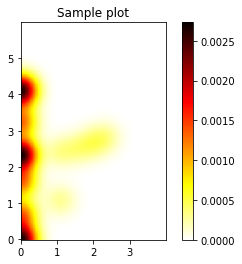

In [558]:
xlim = max_x//50+2
ylim = max_y//50+2
ana.heatmap(ents[:xlim*50, :ylim*50].transpose(1,0), sigma=15, cmap='hot_r')
plt.xticks(np.arange(0,xlim*50, 50), range(xlim))
plt.yticks(np.arange(0,ylim*50, 50), range(ylim))
plt.gca().invert_yaxis()
#plt.savefig('sample.jpg')
#plt.close()

## etc

In [104]:
args = main.get_args('')
ent = util.get_entropy(args, nZ=10)
ents = {k:[] for k in ent}

In [84]:
d_ents = copy.deepcopy(ents)
#uni_ents = copy.deepcopy(ents)

In [95]:
args['f'](9,nU-1)

37

In [120]:
for u in range(2, 11):
    nU = round(1.5**u)
    args = main.get_args(['--Y_fn', '%d*%dd%d' % (1, 8, 1), '--nU', str(nU)])
    ent = util.get_entropy(args, nZ=10)
    for k in ent:
        ents[k].append(ent[k])

In [80]:
for nU in range(2, 20, 2):
    args = main.get_args(['--outcome_fn', 'd%d' % (nU//2), '--nU', str(nU)])
    ent = util.get_entropy(args, nZ=10)
    for k in ent:
        ents[k].append(ent[k])

In [77]:
for u in range(2, 10):
    nU = round(1.5**u)
    args = main.get_args(['--noise', str(nU//2), '--nU', str(nU)])
    ent = util.get_entropy(args, nZ=10)
    for k in ent:
        ents[k].append(ent[k])

Text(0,0.5,'HU')

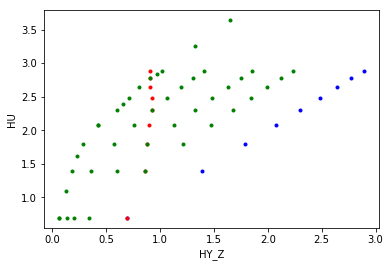

In [121]:
plt.plot(uni_ents['HY_Z'], uni_ents['HU'], 'b.')
plt.plot(d_ents['HY_Z'], d_ents['HU'], 'r.')
plt.plot(ents['HY_Z'], ents['HU'], 'g.')
plt.xlabel('HY_Z')
plt.ylabel('HU')
#plt.xlim(0,)

In [ ]:
for fn in glob.glob('history/*.ent'):
    hist_fns = glob.glob(fn[:-5]+"*.hist")
    if len(hist_fns) == 0:
        continue
    hist = io.pickle_load(hist_fns[0])
    acc = hist['val-acc'][-1]
    ent = io.pickle_load(fn)
    model_name = basename(hist_fns[0])[:-5]
    print(df.loc[model_name])
    df.loc[model_name, 'acc'] = acc
    desc = df.loc[model_name, 'model_type']
    ds = df.loc[model_name, 'dataset']
    xuy = np.load('data/%s/%s_val.npy' % (ds, desc))
    emp_post = util.emp_post(xuy)
    #true_post = util.true_post(xuy[:,:2], args['f'], noise=args['noise'])
    pred_post, pX, pU = util.pred_post(preds, xuy[:,:2])
    #true_KL = util.kl_div(pred_post, true_post, pX, pU)
    emp_KL = util.kl_div(pred_post, emp_post, pX, pU)
    #true_JS = util.js_div(pred_post, true_post, pX, pU)
    emp_JS = util.js_div(pred_post, emp_post, pX, pU)
    
    df.loc[model_name, 'true_KL'] = acc
    print(df.loc[model_name])
    break
    